Let's learn a Lennard-Jones potential (shown in @fig-lj-plot). We'll use a Gaussian process regression aka kernel. Later we will have a look at the effect of a physically motivated prior.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_absolute_error
from dataclasses import dataclass, field
from typing import Literal

In [2]:
def lj(r):
    return 4. * ((1./r)**12 - (1./r)**6)

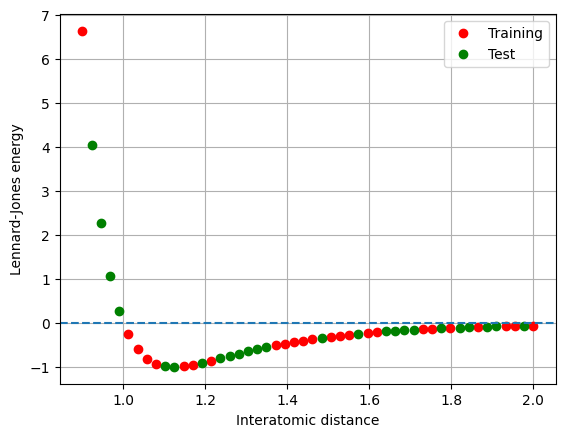

In [3]:
#| label: fig-lj-plot
#| fig-cap: "Lennard-Jones potential as a function of distance"

distances = np.linspace(0.9, 2.0, 50)

X_train, X_test = train_test_split(distances, train_size=0.5, shuffle=True)
y_train, y_test = lj(X_train), lj(X_test)
X_train = X_train.reshape((len(X_train), 1))
X_test = X_test.reshape((len(X_test), 1))


plt.plot(X_train, lj(X_train), 'or', label='Training')
plt.plot(X_test, lj(X_test), 'og', label='Test')
plt.axhline(0, linestyle="--")
plt.xlabel("Interatomic distance")
plt.ylabel("Lennard-Jones energy")
plt.legend()
plt.grid()
plt.show()

In [4]:
@dataclass
class GaussianKernel:
    sigma: float
    regularization: float
    norm: Literal["euclidean", "cityblock"]
    alpha: np.array = field(init=False)
    training_set: np.array = field(init=False)

    def __post_init__(self):
        self.alpha = None
        self.training_set = None

    def get_kernel_matrix(self, x_1: np.array, x_2: np.array) -> np.array:
        return np.exp(- cdist(x_1, x_2, self.norm) / self.sigma)

    def fit(self, x: np.array, y: np.array) -> None:
        self.training_set = x
        regularized_kernel = (
                self.get_kernel_matrix(x, x)
                + self.regularization * np.identity(len(x))
        )
        self.alpha = np.dot(y, np.linalg.inv(regularized_kernel))

    def predict(self, x: np.array) -> np.array:
        assert self.alpha is not None, "Model has not been trained yet!"
        return np.dot(self.alpha, self.get_kernel_matrix(self.training_set, x))

    def mean_absolute_error(self, x: np.array, y: np.array) -> float:
        return mean_absolute_error(y, self.predict(x))

In [5]:
gpr = GaussianKernel(sigma=0.1, regularization=1e-9, norm="cityblock")
gpr.fit(X_train, y_train)
y_predict = gpr.predict(X_test)

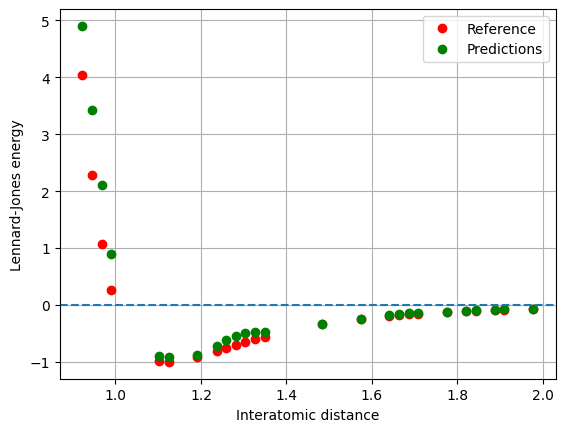

In [6]:
plt.plot(X_test, y_test, 'or', label='Reference')
plt.plot(X_test, y_predict, 'og', label='Predictions')
plt.axhline(0, linestyle="--")
plt.legend()
plt.xlabel("Interatomic distance")
plt.ylabel("Lennard-Jones energy")
plt.grid()
plt.show()

The predictions do well overall, except in the repulsive region, where they severely underestimate. We'll improve upon this later by adding some prior information.

For now, let's compute a learning curve to better assess the quality of the model. We'll do this by averaging several ML models for a number of training set sizes.

In [7]:
gpr.mean_absolute_error(X_test, y_test)

0.18668264361038645

In [8]:
@dataclass
class LearningCurve:
    gpr: GaussianKernel
    input_x: np.array
    target_y: np.array
    number_samples: int = 100

    def score(self, training_ratio: float) -> pd.Series:
        maes = []
        for i in range(self.number_samples):
            x_train_, x_test_ = train_test_split(
                distances, train_size=training_ratio, shuffle=True
            )
            y_train_, y_test_ = lj(x_train_), lj(x_test_)
            x_train_ = x_train_.reshape((len(x_train_), 1))
            x_test_ = x_test_.reshape((len(x_test_), 1))
            self.gpr.fit(x_train_, y_train_)
            maes.append(self.gpr.mean_absolute_error(x_test_, y_test_))
        return pd.Series(data=maes, name=f"{training_ratio}")

    def scores(self, training_ratios: list[float]) -> pd.DataFrame:
        return pd.concat([self.score(ratio) for ratio in training_ratios], axis=1)

In [9]:
learning_curve = LearningCurve(gpr, distances, lj(distances), number_samples=500)
df_scores = learning_curve.scores(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
).describe()

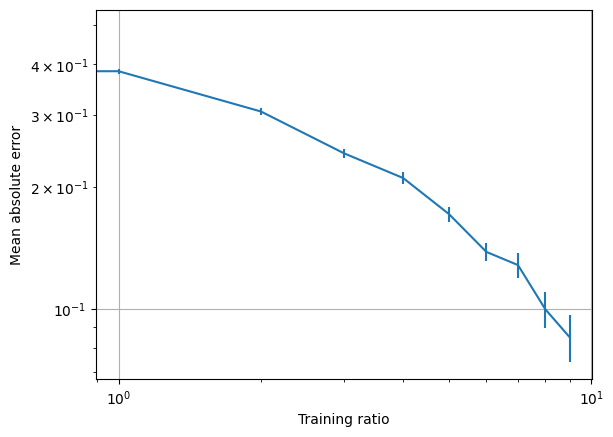

In [10]:
plt.errorbar(
    x=df_scores.columns.values,
    y=df_scores.T["mean"].values,
    yerr=df_scores.T["std"].to_numpy() / np.sqrt(df_scores.T["count"].to_numpy())
)
plt.loglog()
plt.xlabel("Training ratio")
plt.ylabel("Mean absolute error")
plt.grid()
plt.show()

## Adding a prior to the potential

Predictions at short range tend to fail badly, due to difficulties in efficiently learning the divergence. To alleviate this, let's implement a simple linear repulsive prior of the form
$$
 U_{\rm prior} = -\gamma(r-r_0)\theta(r_0-r),
$$
where $\gamma$ and $r_0$ are new hyperparameters, which control the slope and range of the function, respectively. $\theta$ denotes the Heaviside step function (returns 0 if the argument is negative, 1 otherwise).

In [11]:
@dataclass
class GaussianKernelWithPrior(GaussianKernel):
    gamma: float
    r_0: float

    def prior(self, r):
        return -self.gamma * (r - self.r_0) * np.heaviside(self.r_0 - r, 0.)

    def fit(self, x: np.array, y: np.array) -> None:
        self.training_set = x
        regularized_kernel = (
                self.get_kernel_matrix(x, x)
                + self.regularization * np.identity(len(x))
        )
        y_shifted = y - self.prior(x.T[0])
        self.alpha = np.dot(y_shifted, np.linalg.inv(regularized_kernel))

    def predict(self, x: np.array) -> np.array:
        assert self.alpha is not None, "Model has not been trained yet!"
        return (
            self.prior(x.T[0])
            + np.dot(self.alpha, self.get_kernel_matrix(self.training_set, x))
        )


In [12]:
gpr_w_prior = GaussianKernelWithPrior(
    sigma=0.1, regularization=1e-9, norm="cityblock", gamma=150., r_0=0.95
)

In [13]:
gpr_w_prior.fit(X_train, y_train)
gpr_w_prior.mean_absolute_error(X_test, y_test)

0.23125846874605688

In [14]:
learning_curve_w_prior = LearningCurve(
    gpr_w_prior, distances, lj(distances), number_samples=500
)
df_scores_w_prior = (
    learning_curve_w_prior
    .scores([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
    .describe()
)


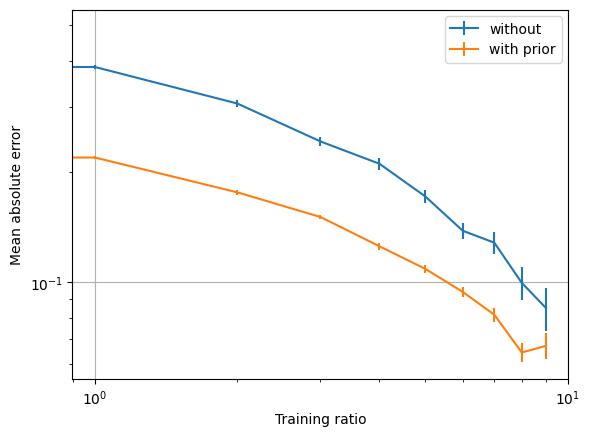

In [15]:
plt.errorbar(
    x=df_scores.columns.values,
    y=df_scores.T["mean"].values,
    yerr=(
        df_scores.T["std"].to_numpy()
        / np.sqrt(df_scores.T["count"].to_numpy())
    ),
    label="without",
)
plt.errorbar(
    x=df_scores_w_prior.columns.values,
    y=df_scores_w_prior.T["mean"].values,
    yerr=(
        df_scores_w_prior.T["std"].to_numpy()
        / np.sqrt(df_scores_w_prior.T["count"].to_numpy())
    ),
    label="with prior",
)
plt.loglog()
plt.legend()
plt.xlabel("Training ratio")
plt.ylabel("Mean absolute error")
plt.grid()
plt.show()

Learning with this simple repulsive prior leads to improved learning performance: while the slope (i.e., learning rate) is roughly the same, the offset is significantly reduced. Note that this is a log-log plot.

Statistical information theory predicts that ML models often learn with a power-law behavior between test error and training-set size
$$
E \sim \beta N^\nu
$$
where the coefficients $\beta$ and $\nu$ dictate the offset and slope of learning, respectively. See papers from Vapnik et al. for more details.